[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_11_cnn-published.ipynb)

# Redes Convolucionales

En este notebook vamos a utilizar capas convoluciones para clasificar imágenes.

Compararemos el desempeño de una red densa con otra convolucional para clasificar imágenes de la base de datos [``EMNIST Letters``](https://www.nist.gov/itl/products-and-services/emnist-dataset). Un *dataset* de letras manuscritas, con 145.600 imágenes de 28x28 píxeles en escala de grises, distribuidas en 26 clases (una por cada letra del alfabeto inglés).

In [117]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np

In [110]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [111]:
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

Separamos los conjuntos que vamos a usar para entrenar y evaluar

In [112]:
train_transform, val_transform = (
    transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

In [113]:
batch_size = 32

train_set, test_set  = (
    datasets.EMNIST(
        root='./data', split='letters', train=True, download=True, transform=train_transform
    ),
    datasets.EMNIST(
        root='./data', split='letters', train=False, download=True, transform=val_transform
    )
)

targets_ = train_set.targets

train_idx, val_idx = train_test_split(np.arange(len(targets_)),
                                      test_size=0.2,
                                      stratify=targets_)

train_sampler, val_sampler = (SubsetRandomSampler(train_idx),
                              SubsetRandomSampler(val_idx))

train_loader, val_loader, test_loader = (
    DataLoader(
        train_set, sampler=train_sampler, batch_size=batch_size, num_workers=2
    ),
    DataLoader(
        train_set, sampler=val_sampler, batch_size=batch_size, num_workers=2
    ),
    DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=2
    )
)


In [114]:
print('Train set size:', len(train_set))
print('Test set size:', len(test_set))

Train set size: 124800
Test set size: 20800


# Exploración de imágenes

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt

In [116]:
def imshow(img):
    img = img / 2 + 0.5 # Desnormalizamos.
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.rot90(npimg, 3)
    npimg = np.fliplr(npimg)
    plt.imshow(npimg)
    plt.show()

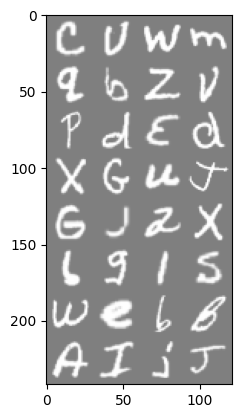

c     g     p     x     g     b     w     a     v     b     d     g     j     g     e     i     w     z     e     u     a     l     b     j     m     v     d     j     x     s     b     j    


In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{train_set.classes[labels[j]]:5s}' for j in range(batch_size)))

# Clasificamos imágenes (Red densa vs convolucional)

Ahora, armemos una red densa para la clasificación de imágenes

In [118]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [185]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 26)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [186]:
dense_net = DenseNet()
dense_net.to(device)

DenseNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=26, bias=True)
)

Entrenamos y evaluamos

In [189]:
for i, batch in enumerate(train_loader, 0):
    # Restamos 1 para que las clases vayan de 0 a 25, en vez de 1 a 26.
    inputs, labels = batch[0].to(device), batch[1].to(device) - 1
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [190]:
from collections.abc import Callable

def train_net(net: nn.Module, train_loader: DataLoader,
              optimizer: optim, criterion: nn, epochs: int = 1):

    for epoch in range(epochs):

        total, running_loss, train_correct = 0, 0.0, 0
        for i, batch in enumerate(train_loader, 0):
            # Restamos 1 para que las clases vayan de 0 a 25, en vez de 1 a 26.
            inputs, labels = batch[0].to(device), batch[1].to(device) - 1
            total += labels.size(0)

            # Reiniciamos los gradientes.
            optimizer.zero_grad()
            # Hacemos la pasada forward.
            outputs = net(inputs)
            # Calculamos la pérdida.
            loss = criterion(outputs, labels)
            # Hacemos la pasada backward.
            loss.backward()
            # Actualizamos los pesos.
            optimizer.step()

            running_loss += loss.item() * inputs.shape[0]

            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        train_loss, train_accuracy = running_loss / total, 100 * train_correct / total,

        # Veamos en validación.
        total, val_loss, val_correct  = 0, 0.0, 0
        with torch.no_grad(): # Esta parte es sólo validación,
                              # no requiere entrenar, por lo que no calculamos gradientes.
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device) - 1
                total += labels.size(0)

                outputs = net(images)

                _, predicted = torch.max(outputs.data, 1) # La ganadora es la que tiene mayor valor.
                val_correct += (predicted == labels).sum().item()

                val_loss += criterion(outputs, labels).item() * images.shape[0]

        val_accuracy, val_loss = 100 * val_correct / total, val_loss / total

        print(f'Epoch {epoch + 1} finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

    print('Finished training.')

In [191]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dense_net.parameters(), lr=learning_rate, momentum=momentum)

train_net(dense_net, train_loader, optimizer, criterion, epochs=2)

Epoch 1 finished. Train accuracy: 71.39%. Validation accuracy: 83.72%.
Epoch 2 finished. Train accuracy: 87.93%. Validation accuracy: 88.48%.
Finished training.


Evaluamos en el conjunto de test

Test accuracy: 88.59%.
Predicted:  a     a     a     a     a    
Ground truth:  a     a     a     a     a    


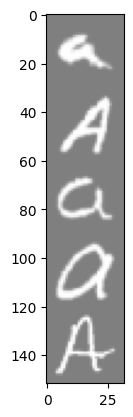

In [236]:
def eval_net(net: nn.Module, test_loader: DataLoader):
  # Calculamos el accuracy para todo el conjunto de test.
  correct, total = 0, 0
  first_predicted, first_labels, first_images = None, None, None
  with torch.no_grad(): # No necesitamos calcular gradientes.

      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device) - 1 # Recordar restar 1 a las etiquetas.

          outputs = net(images)

          _, predicted = torch.max(outputs, 1)

          if first_predicted is None:
              first_predicted, first_labels, first_images = predicted, labels, images

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total

  print(f'Test accuracy: {accuracy:.2f}%.')

  print('Predicted: ', ' '.join(f'{test_set.classes[first_predicted[j] + 1]:5s}' for j in range(5)))
  print('Ground truth: ', ' '.join(f'{test_set.classes[first_labels[j] + 1]:5s}' for j in range(5)))

  # Lo vemos sólo para las primeras 5 imágenes.
  imshow(torchvision.utils.make_grid(first_images[:5].cpu()))

  return first_images, first_predicted, first_labels


first_images, first_predicted, first_labels = eval_net(dense_net, test_loader)

## Probemos una red convolucional

Reemplazar la red densa por una red convolucional que aproveche la estructura espacial de la imagen, **sin aplanarla desde el inicio**. La red debe cumplir con los siguientes requisitos:

- Tener **dos capas convolucionales**:
  - La **primera** debe recibir imágenes de **1 canal** y producir **32 canales**.
  - La **segunda** debe recibir los **32 canales** y producir **64 canales**.
  - Ambas deben usar un **kernel de 3x3**, **stride 1** y **padding 1**.

- Después de **cada capa convolucional**, debe aplicarse:
  - Una función de activación **LeakyReLU**.
  - Una operación de **max pooling** de tamaño **2x2** y **stride 2**.

- Luego de las convoluciones y el aplanamiento:
  - Agregar una **capa lineal** que reciba la salida de las convoluciones (de tamaño **64×7×7**) y la proyecte a **128 unidades**.
  - Usar nuevamente una **activación LeakyReLU**.
  - Finalmente, agregar una **capa lineal de salida** con **26 unidades**, una por cada clase del conjunto **EMNIST Letters**.

> ✏️ **Recordar calcular bien el tamaño de entrada para la capa lineal según el efecto del pooling sobre las dimensiones espaciales.**


In [283]:
from typing import OrderedDict

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self._conv = nn.Sequential(OrderedDict([
        ("conv1", nn.Conv2d(1, 32, 3, padding=1)),
        ("activation1", nn.LeakyReLU()),
        ("maxPool1", nn.MaxPool2d(2)),
        ("conv2", nn.Conv2d(32, 64, 3, padding=1)),
        ("activation2", nn.LeakyReLU()),
        ("maxPool2", nn.MaxPool2d(2)),
        ("aplanamiento", nn.Flatten(1))
    ]))
    self.dense_net = nn.Sequential(
        nn.Linear(64*7*7, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 26)
    )
    self.conv = dict(self.cnn.named_children())

  def forward(self, x):
    return self.dense_net(self._conv(x))

In [240]:
cnn_net = CNN()
cnn_net.to(device)

CNN(
  (cnn): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activatio1): LeakyReLU(negative_slope=0.01)
    (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation2): LeakyReLU(negative_slope=0.01)
    (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (aplanamiento): Flatten(start_dim=1, end_dim=-1)
  )
  (dense_net): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=26, bias=True)
  )
)

Entrenamos y evaluamos como lo hicimos con la red densa

In [241]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_net.parameters(), lr=learning_rate, momentum=momentum)

train_net(cnn_net, train_loader, optimizer, criterion, epochs=2)

Epoch 1 finished. Train accuracy: 82.63%. Validation accuracy: 90.32%.
Epoch 2 finished. Train accuracy: 91.83%. Validation accuracy: 91.94%.
Finished training.


Evaluamos en el conjunto de test

Test accuracy: 91.85%.
Predicted:  a     a     a     a     a    
Ground truth:  a     a     a     a     a    


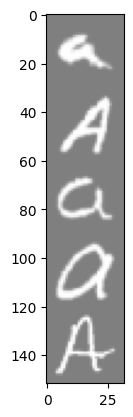

In [242]:
first_images, first_predicted, first_labels = eval_net(cnn_net, test_loader)

**Pregunta:** ¿Cuál tuvo mejor performance?

# ¿Podemos interpretar a la red convolucional?

En esta parte queremos entender qué está haciendo la red, para eso vamos a visualizar los filtros y cómo se aplican a la imagen.

In [243]:
from torchvision import utils

# ch = canal que queremos ver

def vis_tensor(tensor, ch=0, allkernels=False, nrow=8, padding=1, normalize = False):
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h) # -1 dice "no sé cuál es el valor de este parámetro, calculalo"
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  tensor = tensor[:32] # no mostramos más de 32 filtros

  rows = np.min((tensor.shape[0] // nrow + 1, 16))
  grid = utils.make_grid(tensor, nrow=nrow, normalize = normalize, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

Visualizamos los filtros de la primera capa (9x9) para el canal 0 (estamos en escala de grises)

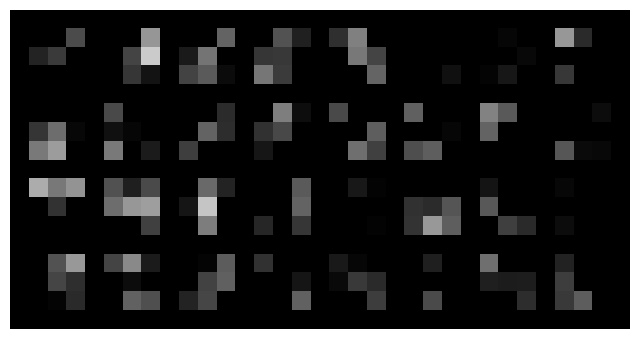

In [244]:
filter = cnn_net.conv['conv1'].weight.data.clone()
vis_tensor(filter.cpu(), ch=0, allkernels=True, normalize=False)

plt.axis('off')
plt.ioff()
plt.show()

También podemos visualizamor los filtros de la segunda capa (3x3)


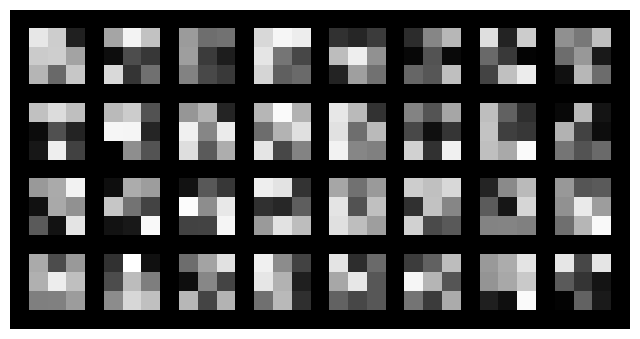

In [245]:
filter = cnn_net.conv['conv2'].weight.data.clone()
vis_tensor(filter.cpu(), normalize = True, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

Los filtros no son demasiado claros. Pero, podemos ver cómo se activan si pasamos una imagen. Por ejemplo, podemos elegir la siguiente imagen:

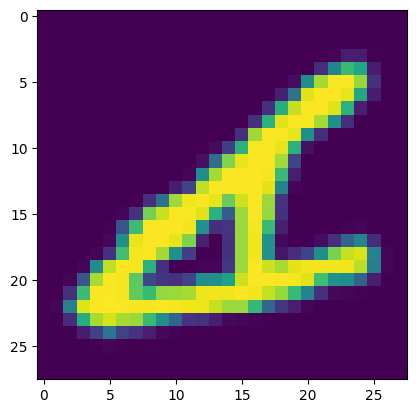

In [246]:
plt.imshow(first_images[1].cpu().squeeze(), cmap='viridis')
plt.show()

In [263]:
# Pass image through the first convolutional layer
conv_layers = [cnn_net.conv["conv1"], cnn_net.conv["activatio1"], cnn_net.conv["maxPool1"],
               cnn_net.conv["conv2"], cnn_net.conv["activation2"], cnn_net.conv["maxPool2"]]

conv_out = [cnn_net.conv["conv1"](first_images[1])]

# Iteratively pass image through all convolutional layers
for i in range(1, len(conv_layers)):
  conv_out.append(conv_layers[i](conv_out[-1]))

In [264]:
def imshow_grid(img, ax, cmap = 'gray', vmin = None):
    img = img / 2 + 0.5 # Desnormalizamos.
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.rot90(npimg, 3)
    npimg = np.fliplr(npimg)
    ax.imshow(npimg, cmap = cmap, vmin = vmin)

Vemos cómo se activa el primer filtro de las redes convolucionales. Es decir, visualizamos el primer mapa de activación resultante de la primera capa

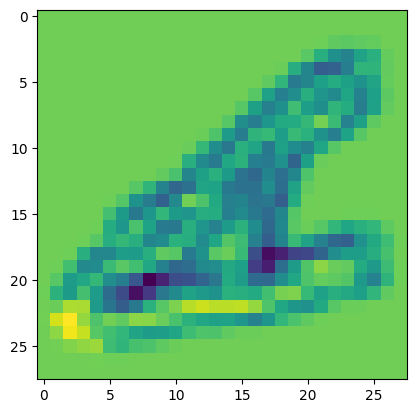

In [276]:
plt.imshow(conv_out[1][0].detach().cpu().squeeze(), cmap='viridis')
plt.show()

O cómo se activa el segundo filtro de las capas convolucionales, es decir, el segundo mapa de activación resultante de la primera capa convolucional:

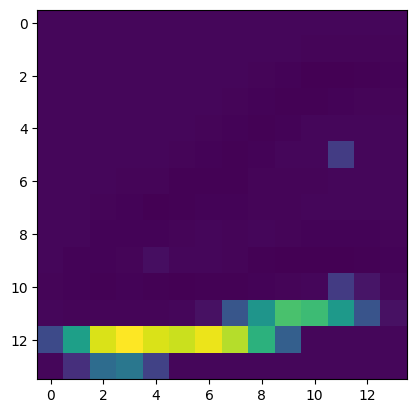

In [277]:
plt.imshow(conv_out[4][1].detach().cpu().squeeze(), cmap='viridis')
plt.show()

Podemos ver cómo se activan los primeros 16 filtros de la primer capa convolucional:

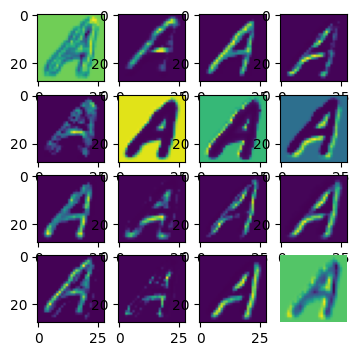

In [278]:
fig, axs = plt.subplots(4, 4, figsize=(4, 4))
fig.gca().set_axis_off()
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())
axs = axs.flatten()
for i in range(0, 16):
  imshow_grid(conv_out[1][i].detach().cpu().unsqueeze(0), axs[i], cmap='viridis')
plt.show()

**Ejercicio**: Visualizar qué pasa después del primer max pool

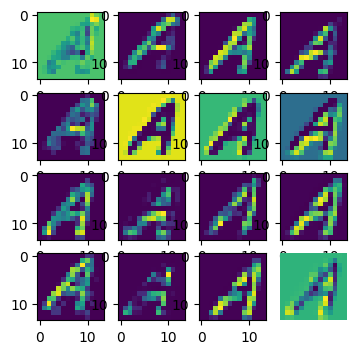

In [279]:
fig, axs = plt.subplots(4, 4, figsize=(4, 4))
fig.gca().set_axis_off()
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())
axs = axs.flatten()
for i in range(0, 16):
  imshow_grid(conv_out[2][i].detach().cpu().unsqueeze(0), axs[i], cmap='viridis')
plt.show()